# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [100]:
# Libraries required for visaulization
import matplotlib.pyplot as plt 
import seaborn as sns
#Libraries required for data importing and data manupulation
import numpy as np 
import pandas as pd 
import math
#  Libraries required for Data Pre-processing and transformation
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

#Data pre processing
import category_encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler 

In [101]:
df = pd.read_csv(r"C:\Users\13309\Downloads\customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [103]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [104]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [105]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [106]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

df.describe()  # Summary stats
df.isnull().sum()  # Missing values
df.nunique()  # Unique values per column


In [107]:
df.describe()  # Summary stats
df.isnull().sum()  # Missing values
df.nunique()  # Unique values per column


num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

## 🧹 Checking for Missing Values

Before proceeding with data preprocessing and model training, it's crucial to check if there are any missing (null) values in the dataset. Missing values can negatively affect model performance and may require imputation or removal. The following code prints the number of null values in each column of the DataFramees.


In [108]:
print(df.isnull().sum())

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


Fortunately, as shown in the output, this dataset is **clean and complete**, with zero missing values across all features.




##📊 Skewness Analysis of Numerical Features

Skewness measures the asymmetry of the distribution of data. It helps us understand whether features are normally distributed or not — a key assumption for many statistical and machine learning models.

- A **skewness > 0** indicates a right-skewed (positively skewed) distribution.
- A **skewness < 0** indicates a left-skewed (negatively skewed) distribution.
- A **skewness ≈ 0** suggests a symmetric (normal-like) distribution.

The code below calculates skewness for all numerical columns in the dataset. High skewness (e.g., > 1 or < -1) may suggest the need for transformation (e.g., log or Box-Cox) to make the data more normally distributed.


In [109]:
# For numerical columns only
skewness = df.select_dtypes(include='number').skew()

# Display skewness
print(skewness)


num_passengers           2.690908
purchase_lead            1.653035
length_of_stay           5.274743
flight_hour              0.396623
flight_day               0.134626
wants_extra_baggage     -0.717239
wants_preferred_seat     0.888762
wants_in_flight_meals    0.294593
flight_duration         -0.360080
booking_complete         1.965292
dtype: float64


C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



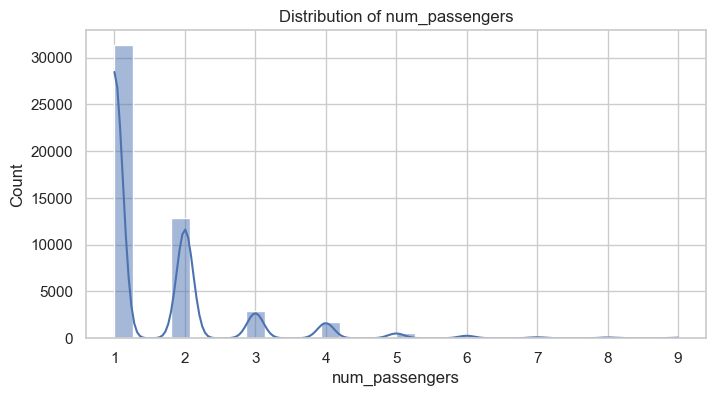

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



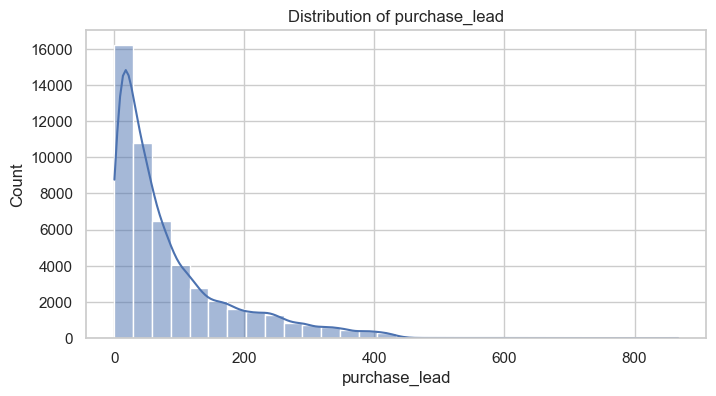

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



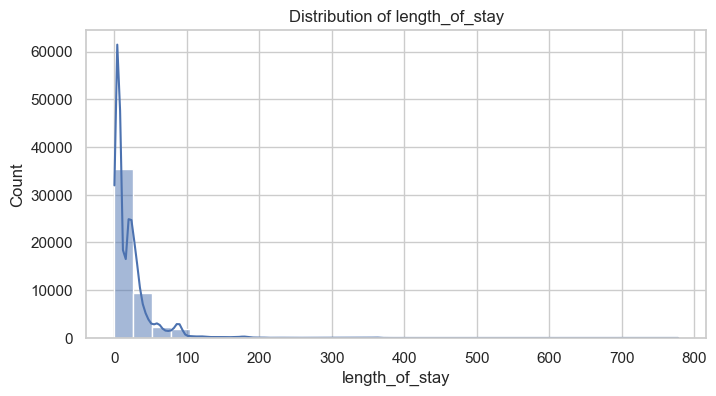

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



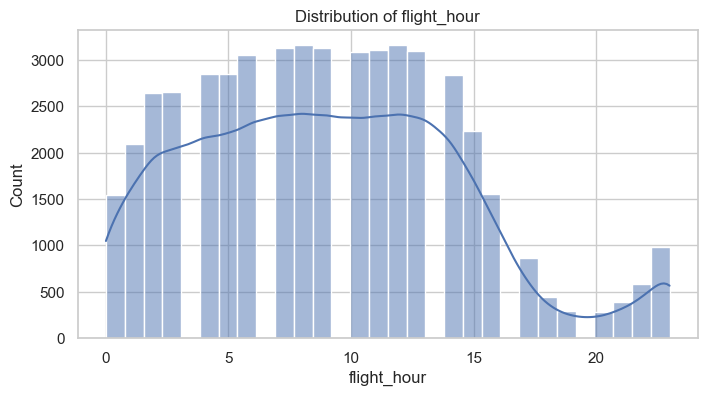

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



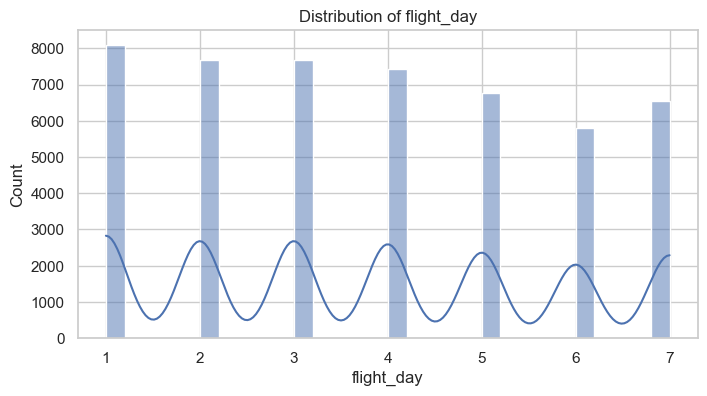

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



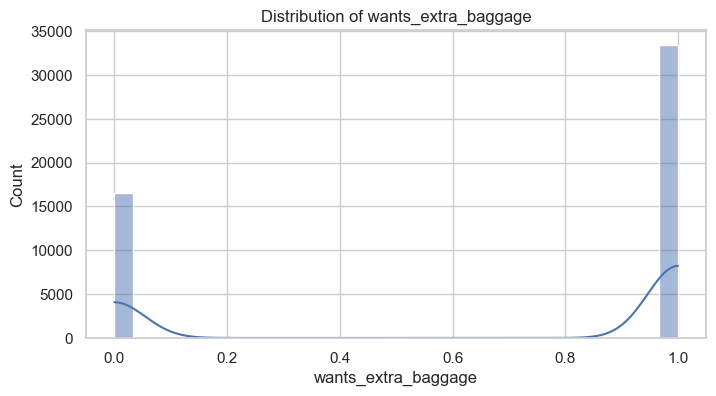

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



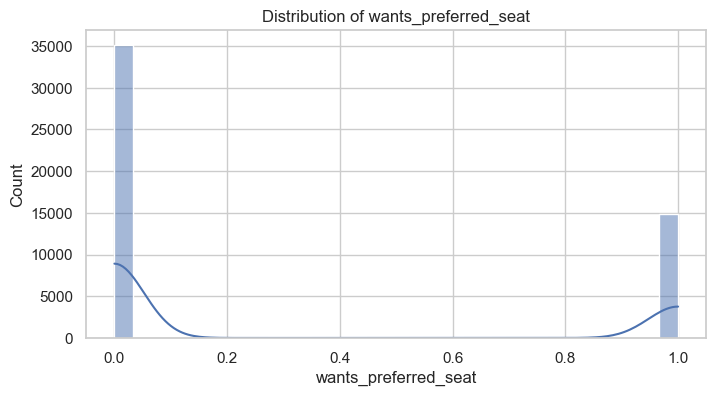

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



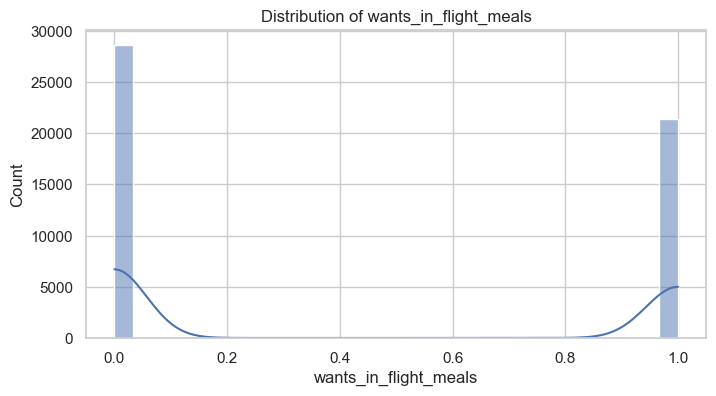

C:\Users\13309\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



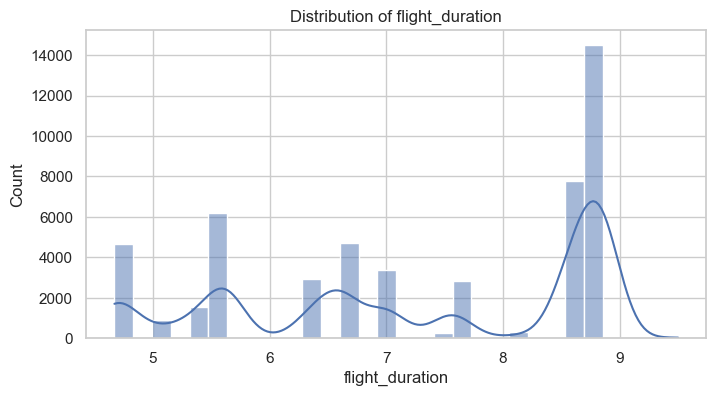

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.drop("booking_complete")

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()


## 📋 Frequency Distribution of Top Categorical Features

This section provides a visual overview of the most frequent categories for each categorical feature in the dataset.

For each categorical column, we display a bar plot of the top 10 most common values. This helps:

- Understand dominant values in each category.
- Identify class imbalance in categorical features.
- Inform feature encoding or grouping decisions.

These visualizations are especially useful during exploratory data analysis (EDA) before applying machine learning models.


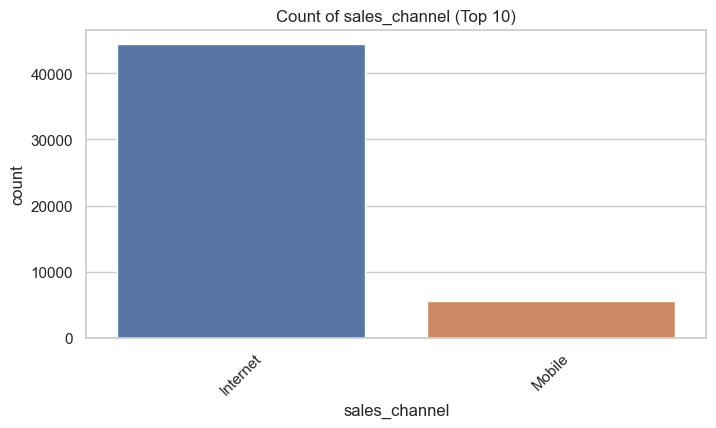

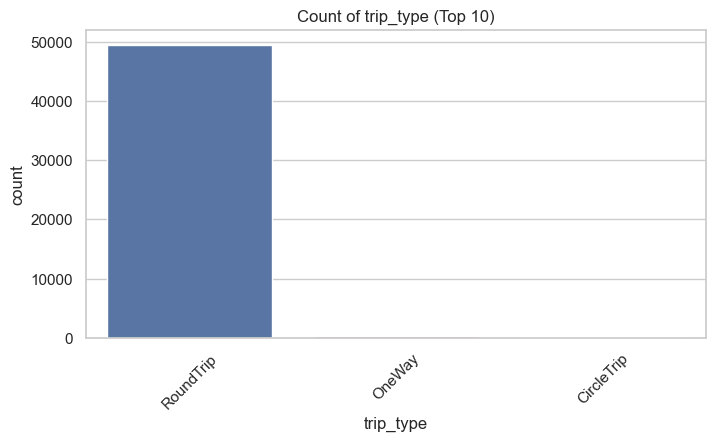

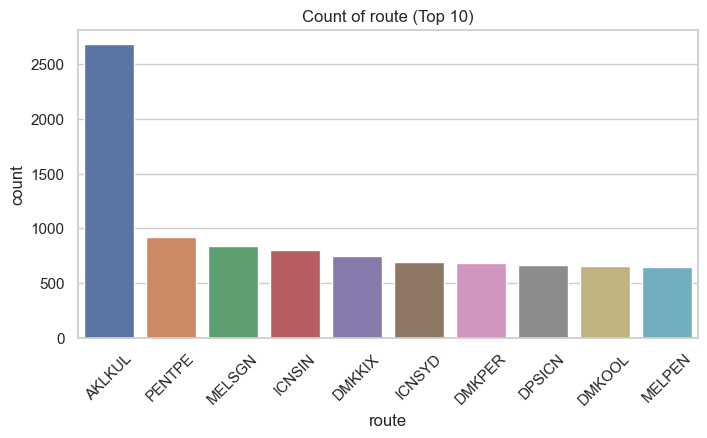

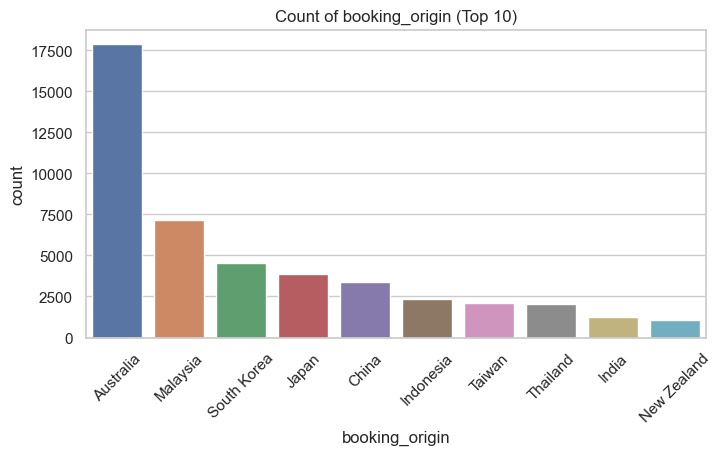

In [111]:
categorical_features = df.select_dtypes(include=["object"]).columns

for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().iloc[:10].index)
    plt.title(f'Count of {col} (Top 10)')
    plt.xticks(rotation=45)
    plt.show()


## 📊 Distribution of Numerical Features by Booking Outcome

This section explores how each numerical feature varies based on whether a booking was completed (`booking_complete` = 1) or not (`booking_complete` = 0).

We use **box plots** to:

- Visualize the central tendency, spread, and potential outliers.
- Compare feature distributions between booking outcomes.
- Identify patterns that may help improve model predictions.

This analysis is helpful to determine how numerical features correlate with the target variable.


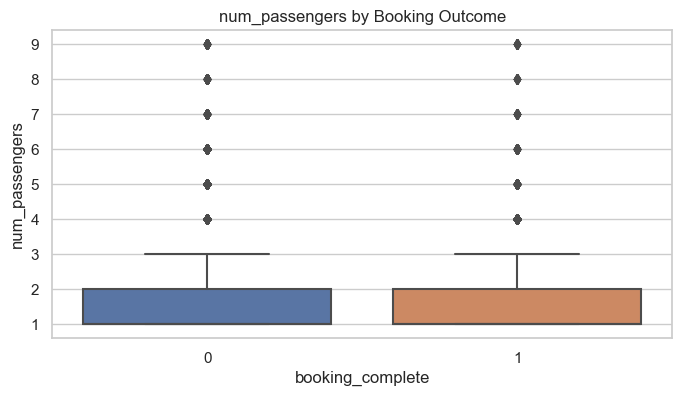

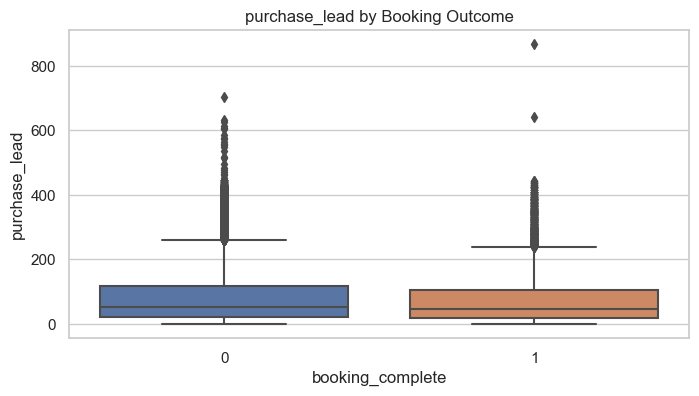

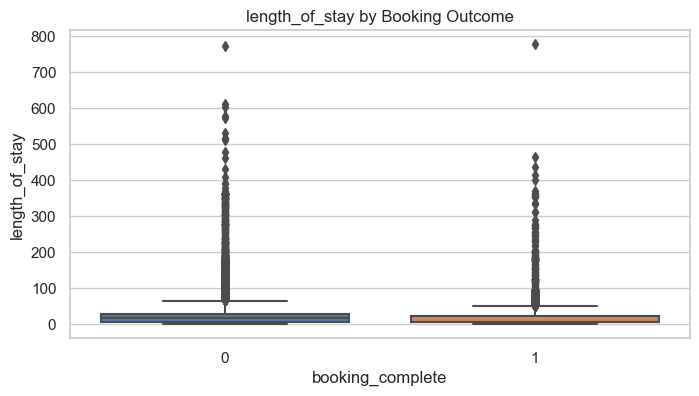

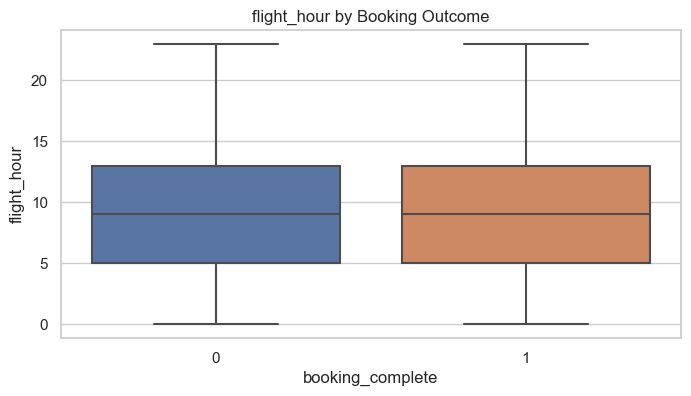

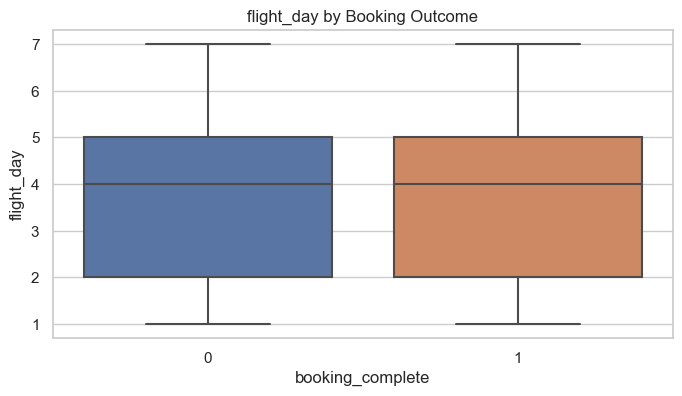

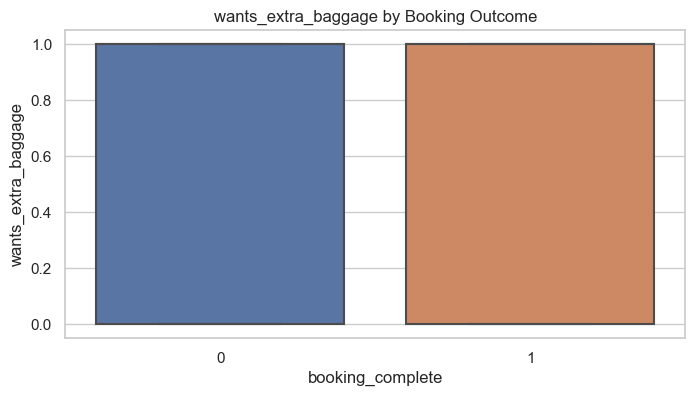

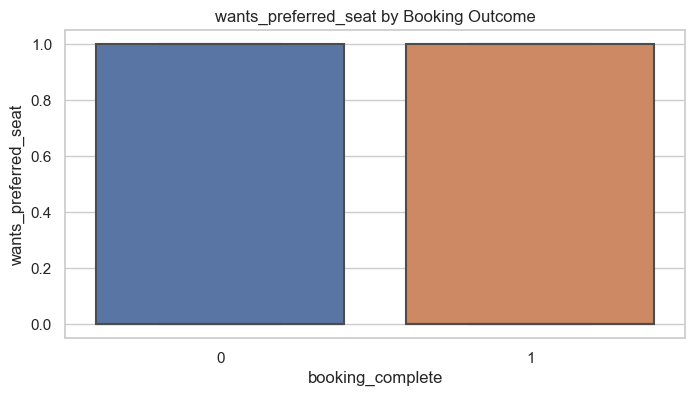

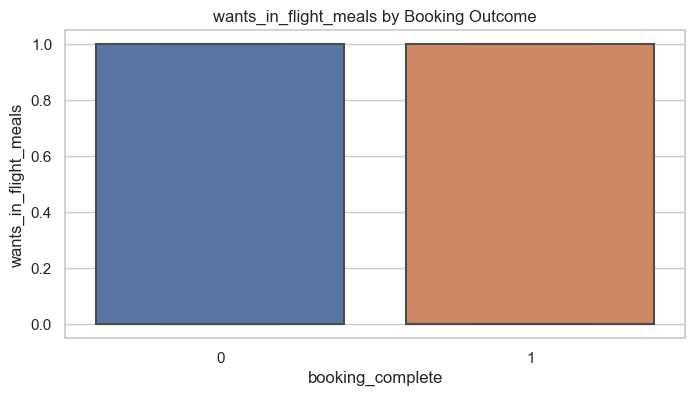

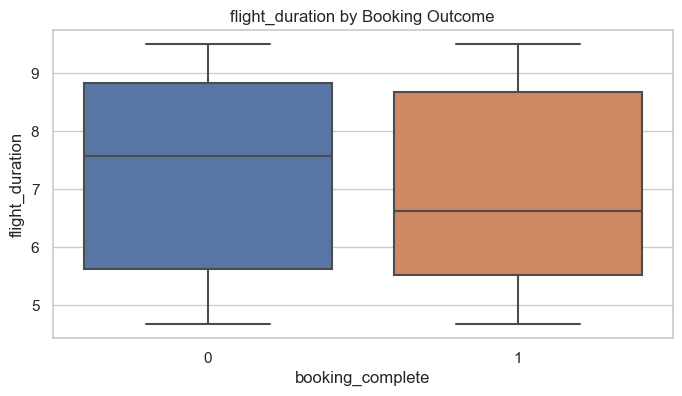

In [112]:
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.drop("booking_complete")

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='booking_complete', y=col, data=df)
    plt.title(f'{col} by Booking Outcome')
    plt.show()


### Booking Completion Rate by Categorical Features

This section visualizes the relationship between each **categorical feature** and the target variable `booking_complete`.

For each categorical column, we compute the **average booking completion rate** for the top 10 most frequent categories. These bar charts help identify which categories are associated with higher booking success rates.

This analysis is useful for:
- Understanding the impact of different categorical variables on customer booking behavior.
- Informing feature selection or encoding strategies.
- Presenting key insights to stakeholders (e.g., which `sales_channel` or `trip_type` contributes most to bookings).



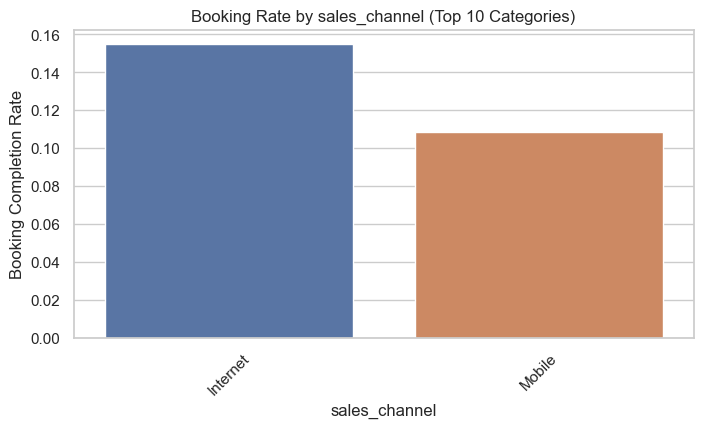

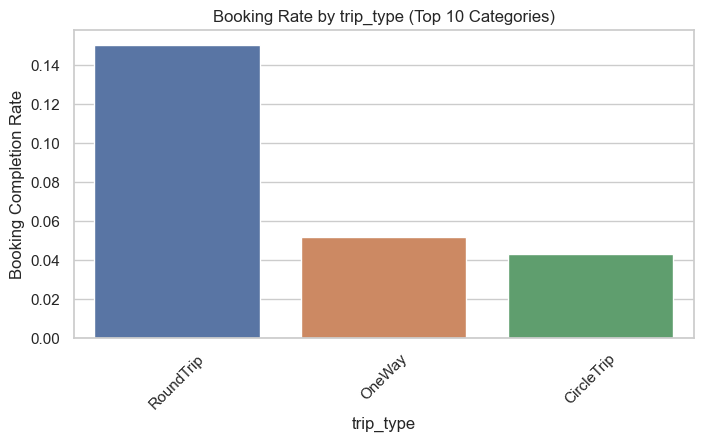

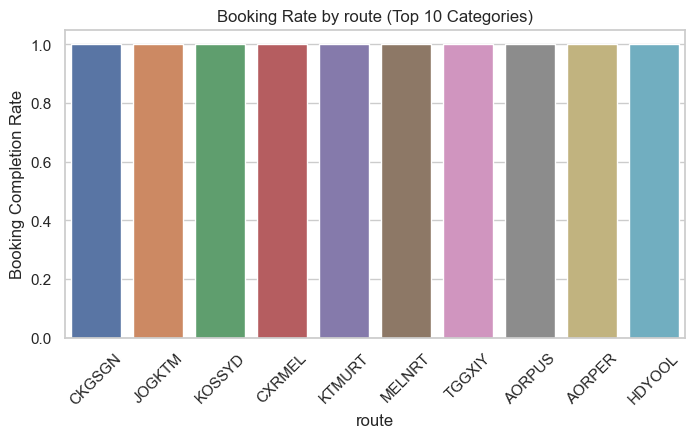

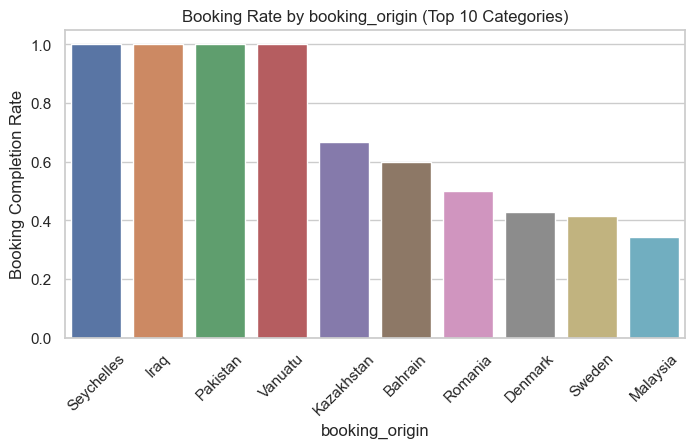

In [113]:
categorical_features = df.select_dtypes(include=["object"]).columns

for col in categorical_features:
    plt.figure(figsize=(8, 4))
    prop_df = df.groupby(col)['booking_complete'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=prop_df.index, y=prop_df.values)
    plt.title(f'Booking Rate by {col} (Top 10 Categories)')
    plt.ylabel('Booking Completion Rate')
    plt.xticks(rotation=45)
    plt.show()


In [114]:
mode1 = df.sales_channel.mode()[0]
mode2 = df.trip_type.mode()[0]
mode3 = df.route.mode()[0] 
mode4 = df.booking_origin.mode()[0]

print(f"mode of sales_channel = {mode1}")
print(f"mode of trip_type = {mode2}")
print(f"mode of route = {mode3}")
print(f"mode of booking_origin = {mode4}")

mode of sales_channel = Internet
mode of trip_type = RoundTrip
mode of route = AKLKUL
mode of booking_origin = Australia


## 📊 Univariate Analysis: Flight Duration Distribution

This visualization presents a stylized boxplot of flight durations in the dataset. The boxplot offers insights into the distribution, median, interquartile range (IQR), and potential outliers in flight duration.

**🎨 Theme:** A clean pastel style with soft lavender and violet shades enhances visual appeal.

**🎯 Purpose:** Helps detect skewness, data spread, and extreme values in flight durations.

**✨ Elements Styled:**
- Colored median line for clarity.
- Pastel box and custom whiskers/caps.
- Gridlines on a subtle background improve readability.

This plot contributes to understanding customer flight behavior and highlights any irregularities that might affect booking predictions or customer preferences.


C:\Users\13309\AppData\Local\Temp\ipykernel_1360\3084750447.py:34: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

C:\Users\13309\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



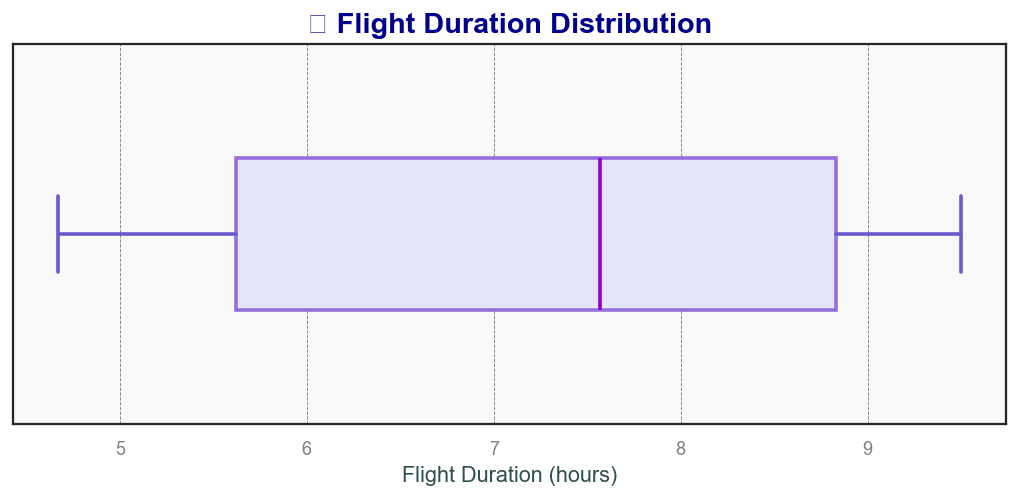

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set aesthetic style
sns.set_theme(style="white", palette="pastel")

# Set figure size and resolution
plt.figure(figsize=(8, 4), dpi=130)

# Customize boxplot with gradient color and enhanced styling
ax = sns.boxplot(
    x='flight_duration',
    data=df,
    width=0.4,
    fliersize=4,
    linewidth=2,
    boxprops=dict(facecolor='lavender', edgecolor='mediumpurple'),
    medianprops=dict(color='darkviolet', linewidth=2),
    whiskerprops=dict(color='slateblue', linewidth=2),
    capprops=dict(color='slateblue', linewidth=2)
)

# Add grid and background color
ax.set_facecolor("#f9f9f9")
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='x')

# Add title and labels with formatting
plt.title('📊 Flight Duration Distribution', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Flight Duration (hours)', fontsize=12, color='darkslategray')
plt.xticks(fontsize=10, color='gray')
plt.yticks(fontsize=10, color='gray')

# Tight layout for better spacing
plt.tight_layout()
plt.show()



[Text(0, 0, 'Incomplete'), Text(0, 1, 'Complete')]

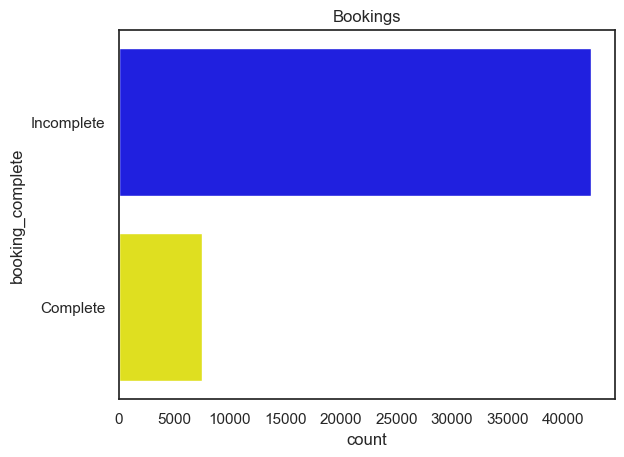

In [116]:
#Plotting the countplot using seaborn
ax = sns.countplot(y=df['booking_complete'],palette=['blue',"yellow"]) 
ax.set_title('Bookings')
ax.set_yticklabels(['Incomplete','Complete'])

## 📊 Interactive Stacked Bar Chart: Booking Completion by Trip Type

This interactive visualization illustrates the distribution of booking completions across different **trip types**. The chart uses a **stacked bar format** to show the number of completed and uncompleted bookings for each trip type.

**✨ Key Features:**
- Built using **Plotly** for interactivity (hover tooltips, zoom, and export).
- Colors are based on the reversed **Reds** sequential palette for visual clarity.
- Displayed values on each bar segment help convey exact counts.

**🎯 Purpose:**
This chart helps identify which trip types are more likely to result in successful bookings, assisting in user behavior analysis and strategy refinement.

Use the interactivity to explore the booking trends dynamically and compare trip types efficiently.


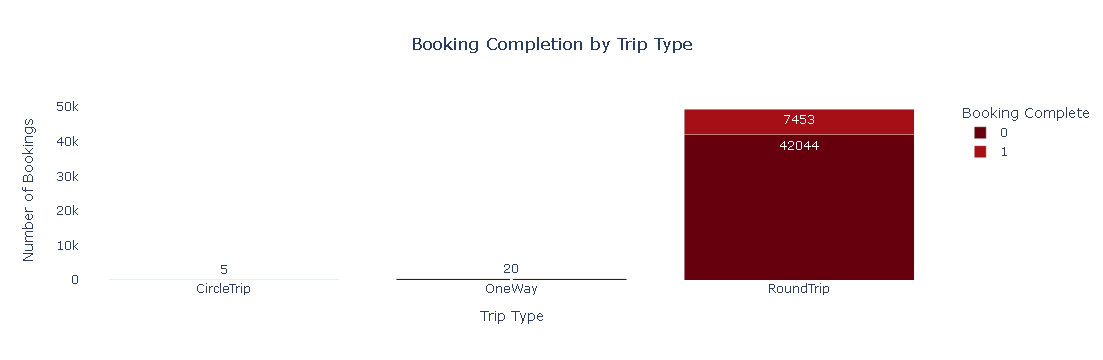

In [117]:
import plotly.express as px
import pandas as pd

# Create a contingency table (same as before)
contingency_table = pd.crosstab(df['trip_type'], df['booking_complete'])

# Convert to a long-form DataFrame for plotly
contingency_table = contingency_table.reset_index()
contingency_table_melted = contingency_table.melt(id_vars='trip_type', 
                                                   value_vars=contingency_table.columns[1:], 
                                                   var_name='booking_complete', 
                                                   value_name='count')

# Interactive stacked bar chart
fig = px.bar(
    contingency_table_melted,
    x='trip_type',
    y='count',
    color='booking_complete',
    title='Booking Completion by Trip Type',
    text='count',
    color_discrete_sequence=px.colors.sequential.Reds[::-1],  # reverse Reds_r
    barmode='stack'
)

fig.update_layout(
    xaxis_title='Trip Type',
    yaxis_title='Number of Bookings',
    title_x=0.5,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    legend_title='Booking Complete'
)

fig.show()


🎯 1. Target Encoding (for High Cardinality Features)
Purpose: Encode high-cardinality categorical features (booking_origin, route) using the mean of the target variable (booking_complete).

Why Target Encoding? It captures the relationship between categories and the outcome, making it ideal for tree-based models or when categories are numerous.



In [119]:
from category_encoders import TargetEncoder
encoder = TargetEncoder(cols=['booking_origin', 'route'])
df[['booking_origin', 'route']] = encoder.fit_transform(df[['booking_origin', 'route']], df['booking_complete'])
df.head()


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,8.379542e-10,0.050279,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,8.379542e-10,0.050279,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,8.379542e-10,0.103150,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,8.379542e-10,0.050279,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,8.379542e-10,0.103150,1,0,1,5.52,0


In [120]:
import pandas as pd

# Example: Assuming your DataFrame is already loaded as `df`
# df = pd.read_csv('your_dataset.csv')  # Uncomment if you're loading from a file

# Encode 'sales_channel' if it exists
if 'sales_channel' in df.columns:
    encoded_sales_channel = pd.get_dummies(df['sales_channel'], drop_first=False).astype(int)
    df = pd.concat([df.drop(columns=['sales_channel']), encoded_sales_channel], axis=1)

# Encode 'trip_type' if it exists
if 'trip_type' in df.columns:
    encoded_trip_type = pd.get_dummies(df['trip_type'], drop_first=False).astype(int)
    df = pd.concat([df.drop(columns=['trip_type']), encoded_trip_type], axis=1)

# Optional: Convert any remaining boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Show the result
print(df.head())


   num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0               2            262              19            7           6   
1               1            112              20            3           6   
2               2            243              22           17           3   
3               1             96              31            4           6   
4               2             68              22           15           3   

          route  booking_origin  wants_extra_baggage  wants_preferred_seat  \
0  8.379542e-10        0.050279                    1                     0   
1  8.379542e-10        0.050279                    0                     0   
2  8.379542e-10        0.103150                    1                     1   
3  8.379542e-10        0.050279                    0                     0   
4  8.379542e-10        0.103150                    1                     0   

   wants_in_flight_meals  flight_duration  booking_complete  Interne

In [121]:
import pandas as pd

# Check if 'sales_channel' exists and encode it
if 'sales_channel' in df.columns:
    encoded_column = pd.get_dummies(df['sales_channel'], drop_first=False)
    df = pd.concat([df.drop(columns=['sales_channel']), encoded_column], axis=1)
else:
    print("⚠️ 'sales_channel' column not found in the DataFrame.")

# Check if 'trip_type' exists and encode it
if 'trip_type' in df.columns:
    encoded_column2 = pd.get_dummies(df['trip_type'], drop_first=False)
    df = pd.concat([df.drop(columns=['trip_type']), encoded_column2], axis=1)
else:
    print("⚠️ 'trip_type' column not found in the DataFrame.")

# Show resulting DataFrame
print(df.head())


⚠️ 'sales_channel' column not found in the DataFrame.
⚠️ 'trip_type' column not found in the DataFrame.
   num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0               2            262              19            7           6   
1               1            112              20            3           6   
2               2            243              22           17           3   
3               1             96              31            4           6   
4               2             68              22           15           3   

          route  booking_origin  wants_extra_baggage  wants_preferred_seat  \
0  8.379542e-10        0.050279                    1                     0   
1  8.379542e-10        0.050279                    0                     0   
2  8.379542e-10        0.103150                    1                     1   
3  8.379542e-10        0.050279                    0                     0   
4  8.379542e-10        0.103150            

In [122]:
scaler = StandardScaler()
# take the target variable out before scaling
df_target = df["booking_complete"].values 
df_predictors = df.drop("booking_complete", axis=1)
# fit_transform returns a NumPy array, so we need to put it back
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(df_predictors)
df = pd.DataFrame(scaled_vals, columns=df_predictors.columns)
# put the non-scaled target back in
df['booking_complete'] = df_target
pd.options.display.max_columns = 200 # inspect the data

df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,CircleTrip,OneWay,RoundTrip,booking_complete
0,0.400684,1.957530,-0.119353,-0.381764,1.096754,-1.231102,-0.913246,0.703747,-0.649919,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
1,-0.579559,0.299164,-0.089844,-1.120780,1.096754,-1.231102,-0.913246,-1.420965,-0.649919,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
2,0.400684,1.747470,-0.030824,1.465775,-0.408687,-1.231102,-0.426962,0.703747,1.538654,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
3,-0.579559,0.122272,0.234761,-0.936026,1.096754,-1.231102,-0.913246,-1.420965,-0.649919,1.158082,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
4,0.400684,-0.187290,-0.030824,1.096267,-0.408687,-1.231102,-0.426962,0.703747,-0.649919,1.158082,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0


In [85]:
from sklearn.model_selection import GridSearchCV
# drop labels for training set, but keep all others

trainset = df.drop("booking_complete", axis=1) 
testset = df["booking_complete"].copy() 
print("Dataset Size : ", trainset.shape, testset.shape)

Dataset Size :  (50000, 16) (50000,)


C:\Users\13309\AppData\Local\Temp\ipykernel_1360\1115948132.py:31: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.

C:\Users\13309\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.



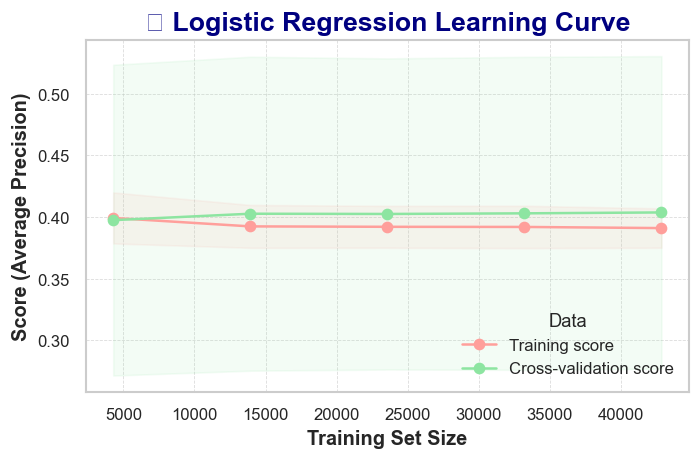

In [87]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Plot the learning curve
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

skplt.estimators.plot_learning_curve(
    LogisticRegression(),
    trainset,
    testset,
    cv=7,
    shuffle=True,
    scoring="average_precision",
    n_jobs=-1,
    title="📈 Logistic Regression Learning Curve",
    ax=ax
)

# Customizing the aesthetics
ax.set_title("📈 Logistic Regression Learning Curve", fontsize=16, fontweight='bold', color='navy')
ax.set_xlabel("Training Set Size", fontsize=12, fontweight='bold')
ax.set_ylabel("Score (Average Precision)", fontsize=12, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Customize ticks and legend
ax.tick_params(axis='both', labelsize=10)
ax.legend(loc='lower right', fontsize=10, title="Data", title_fontsize=11)

# Tight layout for better spacing
plt.tight_layout()
plt.show()


📈 Logistic Regression Learning Curve
Model: Logistic Regression

Metric: Average Precision

Cross-Validation: 7-fold

Insight: Both training and validation scores stabilize around ~0.40, indicating limited model variance and potential underfitting.

This plot helps evaluate model performance as training data increases and diagnose learning behavior.

In [88]:
Xtrain, Xtest, ytrain, ytest = train_test_split(trainset,testset,train_size=0.8,stratify=testset,random_state=1)


In [89]:
lr_classif = LogisticRegression()
lr_classif.fit(Xtrain, ytrain)
lr_classif.score(Xtest, ytest)

0.8505

We got a score of 0.8505, which is above 0.8, indicating the model performs well.


In [90]:
Xtrain.head()


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,CircleTrip,OneWay,RoundTrip
46865,1.380928,1.736415,-0.502977,1.281021,1.096754,0.594118,1.788489,0.703747,-0.649919,-0.863497,0.195370,0.355785,-0.355785,-0.048222,-0.08832,0.100808
28105,0.400684,-0.706912,-0.591506,0.726759,-0.408687,-0.306146,-0.443624,-1.420965,1.538654,1.158082,-0.439297,0.355785,-0.355785,-0.048222,-0.08832,0.100808
39219,0.400684,-0.817469,-0.532487,0.357251,1.598567,1.373409,0.508916,0.703747,-0.649919,-0.863497,-0.439297,0.355785,-0.355785,-0.048222,-0.08832,0.100808
9010,-0.579559,0.066993,-0.178372,0.911513,0.093127,-0.550956,-0.912521,-1.420965,-0.649919,-0.863497,1.037139,-2.810688,2.810688,-0.048222,-0.08832,0.100808
48706,-0.579559,-0.441573,-0.502977,0.911513,-1.412314,0.728925,0.508916,-1.420965,1.538654,1.158082,-0.572911,0.355785,-0.355785,-0.048222,-0.08832,0.100808


In [91]:
ytrain.head()

46865    0
28105    0
39219    0
9010     0
48706    1
Name: booking_complete, dtype: int64

In [92]:
df.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [93]:
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(sampling_strategy='minority') 
Xtrain, ytrain = over.fit_resample(Xtrain,ytrain)

In [94]:
import time
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier(random_state=7)
# specify the hyperparameters and their values
param_grid = { 
    'max_depth':[3,7,10,15,20,25,30,35,40,45,50]
}
# max_depth: Maximum number of levels in tree
grid_search = GridSearchCV(dtc, param_grid, cv=5, 
                           scoring='f1_macro',
                           return_train_score=True,
                           n_jobs = -1)
#Noting the time taken for the model

start = time.time() 
grid_search.fit(Xtrain, ytrain) 
end = time.time() - start 
print(f"Took {end} seconds")

Took 29.245256423950195 seconds


Using `RandomOverSampler` to balance the data, we tuned `DecisionTreeClassifier` with `GridSearchCV` over `max_depth`.  
Training took about 29.25 seconds, optimizing for `f1_macro` with 5-fold CV.


In [36]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=35, random_state=7)

In [37]:
grid_search.best_score_

0.9289518511531867

The best F1 macro score from grid search is **0.929**, indicating strong model performance.


In [38]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

10

In [39]:
import os
from joblib import dump
# create a folder where all trained models will be kept
if not os.path.exists("models"): os.makedirs("models")
dump(grid_search.best_estimator_, 'models/dtc-clf.joblib')

['models/dtc-clf.joblib']

In [40]:
import time
import os
import matplotlib.pyplot as plt
import scikitplot as skplt
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

In [42]:
print("Training Random Forest...")
rf = RandomForestClassifier(random_state=7)

param_grid_rf = {
    'n_estimators': [300, 400],
    'max_depth': [15, 20, 25]
}

grid_search_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)

start = time.time()
grid_search_rf.fit(Xtrain, ytrain)
end = time.time()
print(f"RF Grid search took {end - start:.2f} seconds")


Training Random Forest...
RF Grid search took 1557.28 seconds


Training a Random Forest with GridSearchCV over `n_estimators` and `max_depth` took about **1557.28 seconds** using 5-fold CV and optimizing for `f1_macro`.


In [43]:
# Save best RF model
if not os.path.exists("models"):
    os.makedirs("models")
dump(grid_search_rf.best_estimator_, "models/rf-clf.joblib")


['models/rf-clf.joblib']

In [44]:
# Load and evaluate
best_rf = load("models/rf-clf.joblib")
yhat_rf = best_rf.predict(Xtest)
p, r, f, s = precision_recall_fscore_support(ytest, yhat_rf, average="macro")

print("Random Forest Performance:")
print(f"Precision: {p:.4f}")
print(f"Recall:    {r:.4f}")
print(f"F-score:   {f:.4f}")

Random Forest Performance:
Precision: 0.6695
Recall:    0.6356
F-score:   0.6489


The best Random Forest model was saved and evaluated on the test set.  
**Performance Metrics:**  
- **Precision:** 0.6695  
- **Recall:** 0.6356  
- **F1-score:** 0.6489  
These results indicate decent generalization with balanced performance across classes.


## 🎯 Feature Importance - Random Forest

The following bar chart illustrates the importance of each feature in the Random Forest model. Features such as `route`, `purchase_lead`, and `booking_origin` appear to be the most influential in predicting the target variable.layout()
plt.show()
layout()
plt.show()
layout()
plt.show()


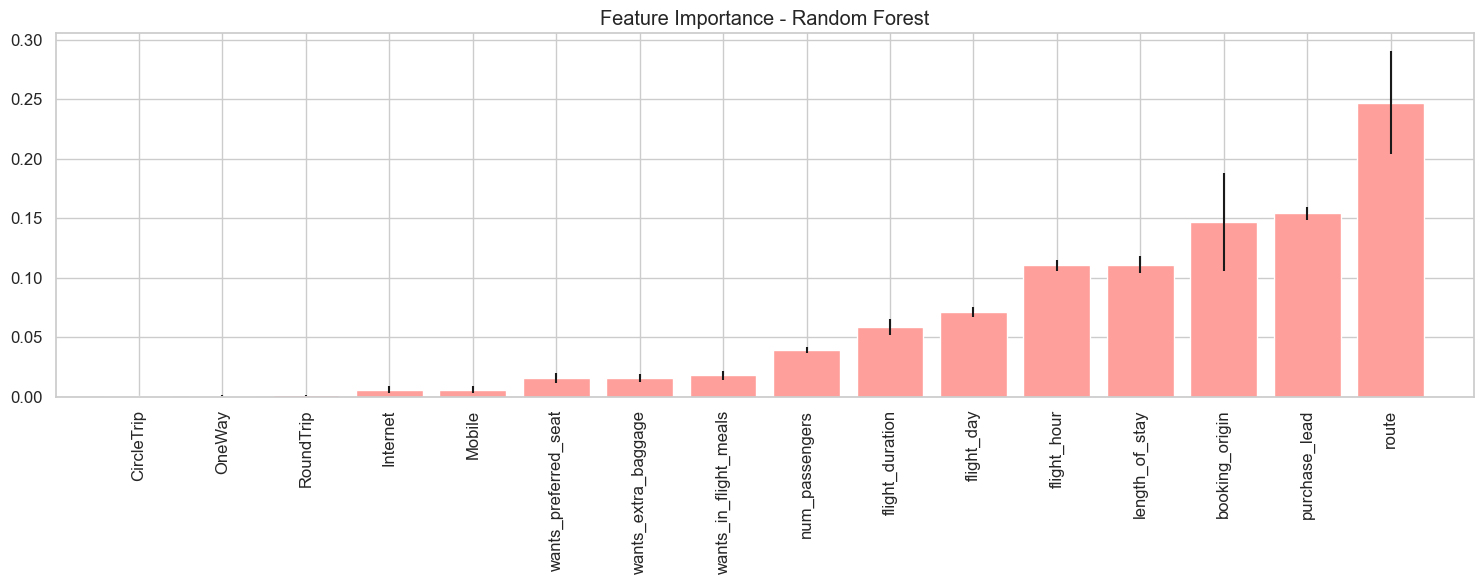

In [125]:
# Feature Importance Plot
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot()
skplt.estimators.plot_feature_importances(
    best_rf,
    feature_names=Xtrain.columns,
    title="Feature Importance - Random Forest",
    x_tick_rotation=90,
    order="ascending",
    ax=ax1
)
plt.tight_layout()
plt.show()

In [46]:
# -----------------------------
# MLP NEURAL NETWORK CLASSIFIER
# -----------------------------
print("\nTraining Neural Network...")
nn = MLPClassifier(random_state=7, max_iter=300)

param_grid_nn = {
    'hidden_layer_sizes': [(50, 2), (75,), (100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

grid_search_nn = GridSearchCV(
    nn,
    param_grid_nn,
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)

start = time.time()
grid_search_nn.fit(Xtrain, ytrain)
end = time.time()
print(f"NN Grid search took {end - start:.2f} seconds")



Training Neural Network...
NN Grid search took 5499.29 seconds


C:\Users\13309\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



## 🤖 MLP Neural Network Classifier

We trained a Multi-layer Perceptron (MLP) neural network classifier using `GridSearchCV` to find the optimal hyperparameters for classification.

### 🔧 Hyperparameter Grid

The following hyperparameters were tuned:

- **hidden_layer_sizes**: `(50, 2)`, `(75,)`, `(100,)`
- **activation**: `'identity'`, `'logistic'`, `'tanh'`, `'relu'`


⏱️ Result
The neural network grid search took approximately 5499.29 seconds (~1.53 hours) to complete.


In [47]:
# Save best NN model
dump(grid_search_nn.best_estimator_, "models/nn-clf.joblib")

['models/nn-clf.joblib']

## 💾 Saving and Evaluating the Best Neural Network Model

After tuning the MLP classifier, we saved the best model using `joblib` and evaluated it on the test dataset.


In [48]:
# Load and evaluate
best_nn = load("models/nn-clf.joblib")
yhat_nn = best_nn.predict(Xtest)
p, r, f, s = precision_recall_fscore_support(ytest, yhat_nn, average="macro")

print("Neural Network Performance:")
print(f"Precision: {p:.4f}")
print(f"Recall:    {r:.4f}")
print(f"F-score:   {f:.4f}")

Neural Network Performance:
Precision: 0.6150
Recall:    0.6976
F-score:   0.6185


## 📉 Normalized Confusion Matrix - MLP Neural Network

The confusion matrix below shows the performance of the MLP Neural Network classifier on the test dataset. Values are normalized, representing the percentage of predictions for each class.


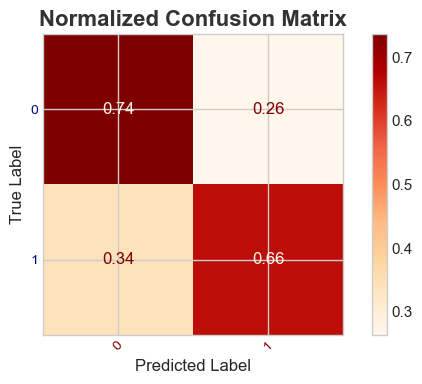

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions first
yhat = best_nn.predict(Xtest)

# Optional: style for nice background
plt.style.use("seaborn-v0_8-whitegrid")

# Create figure and plot
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay.from_predictions(
    ytest,
    yhat,
    labels=best_nn.classes_,
    normalize='true',
    cmap='OrRd',
    ax=ax,
    xticks_rotation=45
)

ax.set_title("Normalized Confusion Matrix", fontsize=16, fontweight='bold', color='#333333')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.tick_params(axis='x', labelsize=10, labelcolor='darkred')
ax.tick_params(axis='y', labelsize=10, labelcolor='darkblue')

plt.tight_layout()
plt.show()


🔍 Insights
The classifier correctly identified 74% of class 0 samples and 66% of class 1 samples.

Misclassification rates were 26% for class 0 and 34% for class 1.